In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [18]:
director = np.load("features_countvec/train_countvec_features_director_name.npy")
actor1 = np.load("features_countvec/train_countvec_features_actor_1_name.npy")
actor2 = np.load("features_countvec/train_countvec_features_actor_2_name.npy")

director_test = np.load("features_countvec/test_countvec_features_director_name.npy")
actor1_test = np.load("features_countvec/test_countvec_features_actor_1_name.npy")
actor2_test = np.load("features_countvec/test_countvec_features_actor_2_name.npy")

df = pd.read_csv("train_dataset.csv")
test = pd.read_csv("test_dataset.csv")

#nullrow = df[df.isnull().any(axis=1)].index[0]
labels = df['imdb_score_binned']

In [19]:
def preproc(df):
    df.average_degree_centrality = pd.qcut(df.average_degree_centrality, 5, labels=[0,1,2,3,4])

    # Fix the genre column

    genres = df['genres'].str.split("|")
    genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

    for x in genres:
        df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

    df.drop(["genres"], axis=1, inplace=True)

    # One hot encode language, country, content_rating
    df = pd.get_dummies(df, columns=["language", "country", "content_rating"], dtype=float)

    ids = df.id
    df = df.iloc[:,2:].select_dtypes(['number'])

    return([df, ids])

In [20]:
df.drop(columns=['imdb_score_binned', 'director_name', 'actor_1_name', 'actor_2_name'], axis=1, inplace=True)
test.drop(columns=['director_name', 'actor_1_name', 'actor_2_name'], axis=1, inplace=True)
Data, ids_train = preproc(df)
Test, ids_test = preproc(test)

In [21]:
# ensure the one hot encoded columns are all the same and in the same order

train_cols = Data.columns
test_cols = Test.columns
missing_levels = train_cols.difference(test_cols)

for x in missing_levels:
    Test[x] = 0
Test = Test[Data.columns]

In [22]:
Test = pd.concat([Test, pd.DataFrame(director_test)], axis=1)
Test = pd.concat([Test, pd.DataFrame(actor1_test)], axis=1)
Test = pd.concat([Test, pd.DataFrame(actor2_test)], axis=1)

Data = pd.concat([Data, pd.DataFrame(director)], axis=1)
Data = pd.concat([Data, pd.DataFrame(actor1)], axis=1)
Data = pd.concat([Data, pd.DataFrame(actor2)], axis=1)

Data.columns = Data.columns.astype(str)
Test.columns = Test.columns.astype(str)

In [23]:
Data_copy = Data.copy() # Make a copy to recall the column names after scaling.

Data_scaler = preprocessing.MinMaxScaler() # create scaler
Data_scaler.fit(Data) #fit scaler
Data = Data_scaler.fit_transform(Data)
Data_df = pd.DataFrame(Data, columns = Data_copy.columns)

Test = Data_scaler.fit_transform(Test)
Test_df = pd.DataFrame(Test, columns = Data_copy.columns)

In [24]:
perf_metric = "accuracy" 
params = {"alpha": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

In [25]:
gs_NB = GridSearchCV(estimator=MultinomialNB(),
                     param_grid=params, 
                     cv=cv_method,
                     verbose=0,
                     scoring=perf_metric)

gs_NB.fit(Data, labels);

In [26]:
print(f"Best parameters: {gs_NB.best_params_}")
print(f"Best score: {gs_NB.best_score_}")

Best parameters: {'alpha': 1.0}
Best score: 0.6320452948789055


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


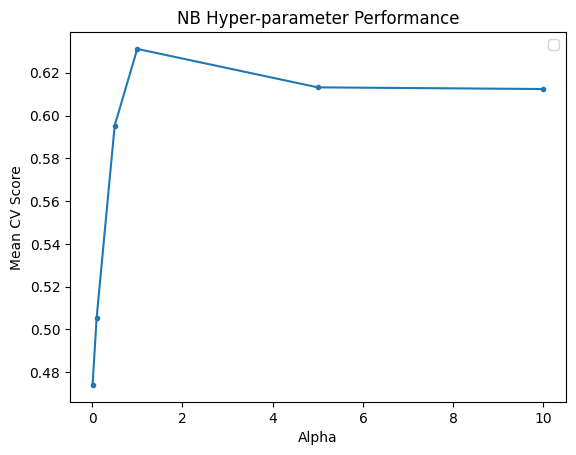

In [11]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

plt.plot(results_NB['alpha'], results_NB['test_score'], marker = '.')
    
plt.legend()
plt.xlabel('Alpha')
plt.ylabel("Mean CV Score")
plt.title("NB Hyper-parameter Performance")
plt.show()

# like before the graph indicates we don't need to search through higher parameters.
# the number of estimators didn't make a huge difference, the 500 and 250 curves are quite similar, 100 estimators 
# has a big jump then behaves like the other curves.

In [12]:
test_pred = gs_NB.predict(Test)

In [13]:
NB_kaggle = pd.DataFrame({'id':ids_test, 'imdb_score_binned': test_pred})
NB_kaggle.to_csv("results_NB_all_cols.csv", index=False)

In [12]:
df.average_degree_centrality.describe()

count    3004.000000
mean        0.001739
std         0.001183
min         0.000300
25%         0.000825
50%         0.001426
75%         0.002401
max         0.007354
Name: average_degree_centrality, dtype: float64